# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS
* Content-based RS
* Item-based collaborative filtering RS
* Hybrid RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [1]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from stop_words import get_stop_words
import nltk
import string
from nltk.corpus import stopwords
from tqdm import tqdm

In [2]:
import pymorphy2
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize

In [3]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

In [4]:
from gensim.models import word2vec

D:\distr\anaconda\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [5]:
from scipy.sparse import vstack
from scipy.sparse import hstack

In [6]:
import pickle

In [59]:

from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [8]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "Video_Games_5.json"
N = 10

## Анализ данных

In [9]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [10]:
df = get_data_frame()
df.head()

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600


In [11]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


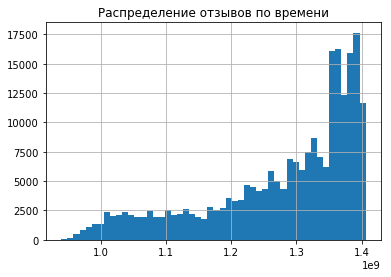

In [12]:
plt.title("Распределение отзывов по времени")
df.dt.hist(bins=50)

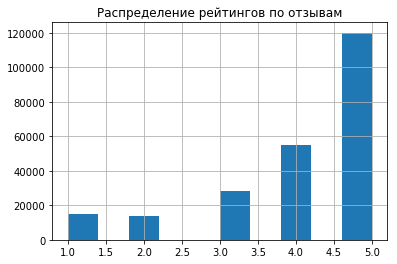

In [13]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [14]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет

array([1], dtype=int64)

In [15]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [16]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [17]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


In [18]:
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [19]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [20]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

## Non-personalized RS

В первом подзадании студент должен построить неперсонализированную рекомендательную систему. Т.е. рекомендации для одного пользователя строятся на основе отзывов, оставленных всеми пользователями.

Ниже приведены базовые классы для рекомендателей, которые можно использовать при построении собственных моделей.

In [21]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid) for uid in uids}
    
class NonPersRecommender(BasicRecommender):
    def __init__(self, df, top):
        self.top=top
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)

        
    def _prepare_recs(self, df):
        return pd.Series([])
    
    def get_recs(self, uid):
 
        return self.recs[:self.top].to_dict()

    
    def get_batch_recs(self, uids):
        non_pers_recs = self.get_recs(None)
        return {uid: non_pers_recs for uid in uids}

Пример неперсональной рекомендательной системы - система, рекомендующая наиболее популярный контент.

In [22]:
class MostReviewedRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df[df.dt>=1280865972].iid.value_counts()  

In [23]:
class NumberOfFife(NonPersRecommender):
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        # 1280865972 - это просто 2010 год что бы исключить слишком старые игры.
        return df[(df.dt>=1280865972) & (df.rating==5)].iid.value_counts()  


In [24]:
class NumberOfFifeRandom2(NonPersRecommender):
    def _prepare_recs(self, df):
        top= self.top
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        tmpdf=df.loc[(df.dt>=1280865972) & (df.rating==5)].iid.value_counts()
        tmpdf=tmpdf.head(4*self.top)
        tmpdf=tmpdf.reset_index()
        tmpdf.columns=['iid', 'five_counts']
        print(tmpdf.head(2))
        sumcounts=np.sum(tmpdf.five_counts)
        tmpdf['p'] = tmpdf.five_counts/sumcounts
        #res = np.random.choice(tmpdf.iid, 10, list(tmpdf.p))
        return pd.DataFrame(res, columns=['iid'] )

In [134]:
class NumberOfFifeRandom(NonPersRecommender):
    def __init__(self, df, top):
        self.top=top
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)    
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df[(df.dt>=1280865972) & (df.rating==5)].iid.value_counts()
    def get_recs(self, uid):
       
        tmpdf=self.recs
        tmpdf=tmpdf.head(20)
        tmpdf=tmpdf.reset_index()
        tmpdf.columns=['iid', 'five_counts']
        #print(tmpdf.head(2))
        sumcounts=np.sum(tmpdf.five_counts)
        tmpdf['p'] = tmpdf.five_counts/sumcounts
        res=[]
        for i in range(0,self.top):
            res.append(np.random.choice(tmpdf.iid, 1, list(tmpdf.p)))
#            print(res[i][0])
            tmpdf=tmpdf.loc[tmpdf.iid != res[i][0]]
        res=pd.DataFrame(res,columns=['iid'])
        res=res.iid.value_counts()
        return res.to_dict() 
    def get_batch_recs(self, uids):
        #non_pers_recs = self.get_recs(None)
        res_dict ={}
        for uid in tqdm(list(uids)):
            res_dict[uid] = self.get_recs(uid)
        return res_dict

In [26]:
#pd=pd.merge(training_df, ttt2, on='iid')

In [27]:
#pd.sort_values('5counts', ascending=False).head()

In [102]:
mrrs=NumberOfFife(training_df, 10)

In [135]:
mrrs_r=NumberOfFifeRandom(training_df,10)

In [136]:
mrrs_r.get_recs(3)

{6492: 1,
 6898: 1,
 7163: 1,
 7591: 1,
 7619: 1,
 7913: 1,
 8151: 1,
 8159: 1,
 8659: 1,
 9267: 1}

In [29]:
def GetTestDicts(df):
    return {uid: {iid: 1 for iid in df.loc[df.uid == uid].iid} for uid in df.uid}

In [30]:
test_dict=get_test_dict(test_df)

In [32]:
train_dict =mrrs.get_batch_recs(test_df.uid.unique())

In [137]:
train_dict_r =mrrs_r.get_batch_recs(test_df.uid.unique())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6815/6815 [01:29<00:00, 76.54it/s]


In [33]:
hit_ratio(recs_dict=train_dict, test_dict=test_dict) #NumberOfFive

0.09948642699926633

In [138]:
hit_ratio(recs_dict=train_dict_r, test_dict=test_dict) #NumberOfFiveRandom - лучше в продакшене

0.06368305209097579

### Подсказки
Подумайте, какие игры обычно приобретают люди. 
* Какие свойства, помимо, популярности могут помочь покупателю выбрать игру, если у него нет явных предпочтений? 
* Можно ли как-нибудь использовать рейтинги или время публикации отзывов?

## Content-based RS

Простая content-based рекомендательная система описывает пользователей и объекты как вектора в некотором N-мерном пространстве фич. Вектор объекта показывает, насколько объект принадлежит к той или иной фиче. Вектор пользователя показывает, насколько пользователь предпочитает ту или иную фичу. Рекомендации строятся путем поиска объектов, чьи вектора похожи на вектор предпочтений пользователя. Предполагается, что чем более похожи вектора пользователя и объекта, тем интереснее этот объект пользователю.

In [34]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN

def normality_me(query):
    tags = nltk.pos_tag(word_tokenize(query))
    words=[]
    for tag in tags:
        wn_tag = penn_to_wn(tag[1])
        words.append(WordNetLemmatizer().lemmatize(tag[0],wn_tag))
    return " ".join(words)     

In [222]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [312]:
training_df.normalized.loc[0]

'installing struggle (because windows live bugs).some championship races cars "unlocked" buying addon game. paid nearly 30 dollars new. dont like idea keep paying keep playing.i noticed improvement physics graphics compared dirt 2.i tossed garbage vowed never buy another codemasters game. im really tired arcade style rally/racing anyway.ill continue get fix richard burns rally, to. :)http://www.amazon.com/richard-burns-rally-pc/dp/b000c97156/ref=sr_1_1?ie=utf8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallythank reading review! if enjoyed it, sure rate helpful.'

In [313]:
training_df.normalized2.loc[0]

'installing struggle (because windows live bugs) some championship races cars unlocked buying addon game paid nearly 30 dollars new dont like idea keep paying keep playing noticed improvement physics graphics compared dirt i tossed garbage vowed never buy another codemasters game really tired arcade style rally racing anyway ill continue get fix richard burns rally to ) reading review if enjoyed sure rate helpful '

In [314]:
normality_me(training_df.normalized2.loc[0])

installing---> instal
struggle---> struggle
(---> (
because---> because
windows---> window
live---> live
bugs---> bug
)---> )
some---> some
championship---> championship
races---> race
cars---> car
unlocked---> unlock
buying---> buy
addon---> addon
game---> game
paid---> pay
nearly---> nearly
30---> 30
dollars---> dollar
new---> new
dont---> dont
like---> like
idea---> idea
keep---> keep
paying---> pay
keep---> keep
playing---> playing
noticed---> noticed
improvement---> improvement
physics---> physic
graphics---> graphic
compared---> compare
dirt---> dirt
i---> i
tossed---> toss
garbage---> garbage
vowed---> vow
never---> never
buy---> buy
another---> another
codemasters---> codemasters
game---> game
really---> really
tired---> tired
arcade---> arcade
style---> style
rally---> rally
racing---> race
anyway---> anyway
ill---> ill
continue---> continue
get---> get
fix---> fix
richard---> richard
burns---> burn
rally---> rally
to---> to
)---> )
reading---> read
review---> review
if---> if

In [52]:
stop_words = stopwords.words('english')

In [206]:
def tokenize_me(file_text):
    #file_text=file_text.text
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)
    #print(file_text)
    tokens=file_text.split(" ")
    #deleting stop_words
    stop_words = stopwords.words('english')
    stop_words.extend(['game', 'games', 'the', 'this', 'it', 'its'])
    tokens = [i for i in tokens if ( (i not in stop_words) & (len(i)>1) )]

    #cleaning words
    tokens = [i.replace("«", "").replace("»", "").replace("'", "").replace("`", "") for i in tokens]

    return tokens

In [55]:
class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = tokenize_me(s)
        return " ".join([self.__call__(w) for w in words])

In [56]:
morph = MorphProvider()

In [57]:
training_df["normalized"] = [morph.morph_string(t) for t in tqdm(training_df.review)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185427/185427 [16:45<00:00, 184.34it/s]


In [494]:
#training_df['normalized'] = training_df.normalized.apply( tokenize_me)

In [58]:
training_df.normalized.head(5)

0    installing struggle (because windows live bugs...
1    if like rally cars get fun.it oriented &#34;eu...
3    got version instead ps3 version, turned mistak...
4    dirt xbox 360 okay game. started playing lapto...
5    overall well done racing game, good graphics t...
Name: normalized, dtype: object

In [309]:
good1 = re.compile('\(+\:+')
good2 = re.compile('\:+\)+')
bad1 = re.compile('\:+\(+')
bad2 = re.compile('\)+\:+')
matchlist = [re.compile('http:\/\/.*?\s'),
             re.compile('https?:\/\/.*\s'),
             re.compile('/<[A-Za-z\/][^>]*>/'), 
             re.compile('୧ʕ•̀ᴥ•́ʔ୨'), 
             re.compile('<br>'), 
             re.compile('/\s.\s/'), 
             re.compile('[\.,\'\"\?\!;\:\-\*\&\#\/]+')]

muchspase = re.compile('\s+')
matchxbox_list = [
                  re.compile('/\bx\s*box\s*\d+\b/'),
                  re.compile('\bx\s*box\s*\d+\b'),
                  re.compile('/x\s+box/'),
                  re.compile('/^xbox/'),
                  re.compile('x\s+box'),    
                  re.compile('/\s360\s/'),
                  re.compile('\s360\s'),

 ]
matchps = [re.compile('ps\d'),
           re.compile('sony play station\s*\d'),
           re.compile('play station\s*\d')
          ]

In [280]:
training_df['normalized2'] = training_df.normalized

In [281]:
training_df['normalized2'] = training_df.normalized.replace(to_replace=good1, value=r" good ", regex=True)
training_df['normalized2'] = training_df.normalized.replace(to_replace=good2, value=r" good ", regex=True)

In [282]:
training_df['normalized2'] = training_df.normalized.replace(to_replace=bad1, value=r" bad ", regex=True)
training_df['normalized2'] = training_df.normalized.replace(to_replace=bad2, value=r" bad ", regex=True)

In [310]:
for match in matchlist:
    training_df['normalized2'] = training_df.normalized2.replace(to_replace=match, value=r" ", regex=True)
    

In [284]:
training_df.normalized2=training_df.normalized2.replace(to_replace='\sx\s*box\s*\d+\s', value=r" microsoft ", regex=True)

In [285]:
for match in matchxbox_list:
    training_df['normalized2'] = training_df.normalized2.replace(to_replace=match, value=r" microsoft ", regex=True)

In [286]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace=match, value=r" ", regex=True)

In [287]:
for match in matchps:
    training_df['normalized2'] = training_df.normalized2.replace(to_replace=match, value=r" sony ", regex=True)

In [288]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace=matchps, value=r" ", regex=True)

In [289]:
training_df['normalized'].head()

0    installing struggle (because windows live bugs...
1    if like rally cars get fun.it oriented &#34;eu...
3    got version instead ps3 version, turned mistak...
4    dirt xbox 360 okay game. started playing lapto...
5    overall well done racing game, good graphics t...
Name: normalized, dtype: object

In [290]:
training_df['normalized2'].head()

0    installing struggle (because windows live bugs...
1    if like rally cars get fun it oriented  34 eur...
3    got version instead  sony  version  turned mis...
4    dirt microsoft okay game  started playing lapt...
5    overall well done racing game  good graphics t...
Name: normalized2, dtype: object

In [291]:
#w2v = word2vec.Word2Vec(training_df.review, size=200)

In [292]:
training_df.loc[training_df.normalized2.str.match('\snt\s')].normalized2

Series([], Name: normalized2, dtype: object)

In [293]:

# training_df['normalized2'] = training_df.normalized2.replace(to_replace='\s.\s', value=r" ", regex=True)
# training_df['normalized2'] = training_df.normalized2.replace(to_replace='^.\s', value=r" ", regex=True)
# training_df['normalized2'] = training_df.normalized2.replace(to_replace='ca nt', value=r"can not", regex=True)    


In [294]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\snt\s', value=r"not", regex=True)

In [295]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\sim\s', value=r" ", regex=True)

In [296]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='^im\s', value=r" ", regex=True)

In [297]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\s.\s', value=r" ", regex=True)

In [298]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\sits\s', value=r" ", regex=True)

In [299]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\sit\s', value=r" ", regex=True)

In [300]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace='\sthis\s', value=r" ", regex=True)

In [311]:
training_df['normalized2'] = training_df.normalized2.replace(to_replace=muchspase, value=r" ", regex=True)

In [ ]:
training_df["normalized3"] = [normality_me(t) for t in tqdm(training_df.normalized2)]

In [321]:
file = open('training_df2', 'wb')
pickle.dump(training_df, file)
file.close()

In [322]:
training_df.loc[training_df.iid==0].normalized3

0     instal struggle ( because window live bug ) so...
1     if like rally car get fun orient 34 european m...
3     get version instead sony version turn mistake ...
4     dirt microsoft okay game start play laptop buy...
5     overall well do racing game good graphic time ...
6     love play dirt think graphic good purchase dir...
7     cant tell piece dog be like everything else mi...
8     initially give one star crash constantly recen...
10    quite finish game dirt tour mode believe ive e...
11    play car racing since early begin pc currently...
14    crash vista codemasters tell dont support wind...
15    this rip off less terrain less track less feat...
16    in todays market easy miss race arent part lic...
17    this really step dirt well graphic car seem li...
18    this bug landfirst problem instal required win...
20    lot people dont like rally already try gran tu...
21    would like give star could get run like others...
22    the great game windows live frustrate piec

In [60]:
tfidf = TfidfVectorizer(stop_words='english',analyzer='word')
tfidf.fit(training_df.normalized3)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [324]:
ftr_id_to_term = {ftr_id: term for term, ftr_id in tfidf.vocabulary_.items()}

In [325]:
item_profile = tfidf.transform([training_df.loc[5].normalized3])
item_profile 
for ftr_id, score in sorted(zip(item_profile.indices, item_profile.data), key=lambda x: x[1], reverse=True):
    print(ftr_id_to_term[ftr_id], ":", score)

mees : 0.305559211964
log : 0.301006623863
live : 0.295674421404
window : 0.260600183086
rebuy : 0.250717062338
necessity : 0.186032606883
controller : 0.183218740568
activation : 0.178309378766
suffers : 0.164210527786
dirt : 0.161801817348
star : 0.161390120936
detract : 0.159683083907
accept : 0.155084495551
steer : 0.153063915006
racing : 0.151387072518
customer : 0.14358740893
greatly : 0.142202213591
keyboard : 0.136592528016
wheel : 0.135149429338
period : 0.130419682504
code : 0.125933997291
personally : 0.118685511523
impossible : 0.11859397509
play : 0.118321994783
family : 0.117126860521
longer : 0.116564935942
flaw : 0.11464464362
support : 0.112872269163
progress : 0.112224151254
box : 0.109596146035
deal : 0.101438183473
type : 0.0903219635282
save : 0.0877373233363
probably : 0.0868704083629
online : 0.0864243179229
feature : 0.0861187470113
overall : 0.0775707232635
enjoy : 0.0765085893918
game : 0.0761592951554
work : 0.068575538145
think : 0.0634699777192
want : 0.063

In [478]:
#review_tf=tfidf.transform(training_df.normalized2)

In [527]:
training_df.uid.nunique()/ training_df.iid.nunique()

2.1999405822935234

n/m получается больше 2, возьмем больше 5

In [564]:
training_df2 = training_df.copy()

In [560]:
iid_nums=None

In [ ]:
# список фильмов и пользователей имеющих достаточное кол-во объектов (5 взята из телеграма и не подбиралась)

In [51]:
iid_nums = training_df.groupby('iid').uid.count()
iid_nums = iid_nums.reset_index()
iid_nums.columns=['iid', 'num']
iid_nums = iid_nums.loc[iid_nums.num>5]
iid_nums.shape

(7906, 2)

In [52]:
uid_nums = training_df.groupby('uid').iid.count()
uid_nums = uid_nums.reset_index()
uid_nums.columns =['uid', 'num']
uid_nums = uid_nums.loc[uid_nums.num>5]
uid_nums.shape

(12312, 2)

In [934]:
list(training_df.loc[training_df.rating >=4].iid)[-2:]

[10385, 10385]

In [ ]:
# X_g = []

# i=0
# iid=None
# tmp=[]
# end_i=(len(training_df.loc[training_df.rating>=5].iid)-1)
# for row in training_df.loc[training_df.rating>=5].itertuples():
#     if  row not in list(iid_nums.iid):
#         continue
#     if (i>0) & (row.iid != iid):
#         X_g.append(tmp)
#         iid=row.iid
#         tmp=(tfidf.transform([row.normalized2]))*row.rating
#     if  (i>0) & (row.iid == iid):
#         tmp = tmp + (tfidf.transform([row.normalized2]))*row.rating
#     if i==0:
#         tmp = (tfidf.transform([row.normalized2]))*row.rating
#         iid=row.iid
#     if i==end_i:
#         X_g.append(tmp)
#     i+=1

In [215]:
training_df.loc[training_df.iid==0].normalized2

0     installing struggle (because windows live bugs...
1     if like rally cars get fun it oriented 34 euro...
3     got version instead sony version turned mistak...
4     dirt microsoft okay game started playing lapto...
5     overall well done racing game good graphics ti...
6     loved playing dirt thought graphics good purch...
7     cant tell piece dog is like everything else mi...
8     initially gave one star crashing constantly re...
10     quite finished games dirt tour mode believe i...
11    playing car racing since early beginning pc cu...
14    crashed vista codemasters told dont support wi...
15    this rip off it less terrain less tracks less ...
16    in todays market its easy miss racing arent pa...
17    this really step dirt 2 better graphics cars s...
18    this bug landfirst problems installing require...
20    lot people dont like rally already tried gran ...
21    would like give stars could get run like other...
22    the great games windows live frustrating p

In [435]:
X_g = []


i=0
iid=None
tmp=[]
end_i=(len(training_df.loc[training_df.rating>=5].iid)-1)
for iid in iid_nums.iid:
    tmp = tfidf.transform(training_df.loc[training_df.iid==iid].normalized3)
    X_g.append(tmp.sum(axis=0)) 

In [457]:
i=0
for row in X_g:
    X_g[i]=csr_matrix(row)
    i+=1

In [459]:
X_g.shape

(7906, 191419)

## Попробуем определить систему клоторой пользуется пользователь (спойлер- не получилось) 

In [327]:
systemdict = {0: 'other', 2: 'microsoft', 2: 'sony', 3: 'nintendo'}

In [557]:
#iid_nums

In [452]:
iid_nums['system'] = 0

In [453]:
sonyiids = list(training_df.loc[training_df.normalized3.str.match('sony') | training_df.normalized3.str.match('ps\s')].iid)
microsoftiids = list(training_df.loc[training_df.normalized3.str.match('microsoft') 
                                     | training_df.normalized3.str.match('xbox') | training_df.normalized3.str.match('360')].iid)
nintendoiids = list(training_df.loc[training_df.normalized3.str.match('nintendo')].iid)

In [454]:
i=0
for iid in iid_nums.iid:
    if iid in microsoftiids:
        iid_nums.system.iloc[i] = iid_nums.system.iloc[i]+1
    if iid in sonyiids:
        iid_nums.system.iloc[i] = iid_nums.system.iloc[i]+5        
    if iid in nintendoiids:
        iid_nums.system.iloc[i] = iid_nums.system.iloc[i]+15    
    i=i+1    

In [455]:
iid_nums.system.loc[(iid_nums.system != 1) & (iid_nums.system != 5) & (iid_nums.system != 15)] = 0

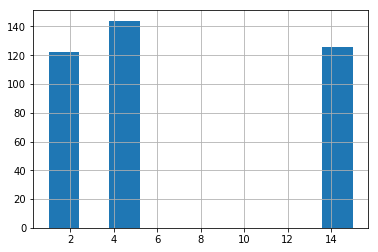

In [456]:
iid_nums.loc[iid_nums.system != 0].system.hist()

In [439]:
#training_df.loc[].normalized3

In [460]:
# X_g_neg = []
# y_g_neg = []
# i=0
# iid=None
# tmp=[]
# end_i=(len(training_df.loc[training_df.rating <=3].iid)-1)
# for row in training_df.loc[training_df.rating <=3].itertuples():
        
#     if (i>0) & (row.iid != iid):
#         X_g_neg.append(tmp)
#         iid=row.iid
#         tmp=(tfidf.transform([row.review]))*row.rating
#     if  (i>0) & (row.iid == iid):
#         tmp = tmp + (tfidf.transform([row.review]))*row.rating
#     if i==0:
#         tmp = (tfidf.transform([row.review]))*row.rating
#         iid=row.iid
#     if i==end_i:
#         X_g_neg.append(tmp)
#     i+=1

In [458]:

X_g = vstack(X_g, 'csr')

In [61]:
X_g_file=open('tfidf', 'wb')
pickle.dump(tfidf, X_g_file)
X_g_file.close()

In [38]:
training_df['normalized3'] = training_df2.normalized3

In [477]:
training_df['system'] = 0

In [479]:
sony_bool_list=training_df.normalized3.str.match('sony') | training_df.normalized3.str.match('ps\s')

In [481]:
microsoft_bool_list = training_df.normalized3.str.match('microsoft') \
                                     | training_df.normalized3.str.match('xbox') | training_df.normalized3.str.match('360')

In [482]:
nintendo_bool_list = training_df.normalized3.str.match('nintendo')

In [483]:
training_df.loc[sony_bool_list, 'system'] = training_df.loc[sony_bool_list, 'system'] + 5
training_df.loc[microsoft_bool_list, 'system'] = training_df.loc[microsoft_bool_list, 'system'] +  1
training_df.loc[nintendo_bool_list, 'system'] =  training_df.loc[nintendo_bool_list, 'system'] + 15

In [485]:
training_df.loc[(training_df.system != 1) & (training_df.system != 5) & (training_df.system != 15)] = 0

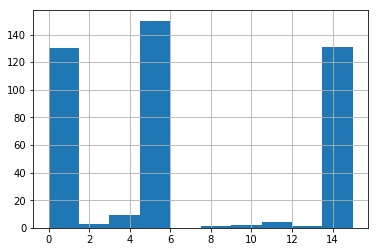

In [488]:
training_df.groupby('iid').system.mean().hist()

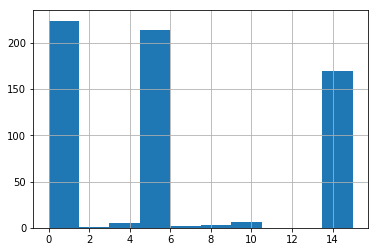

In [489]:
training_df.groupby('uid').system.mean().hist()

In [61]:
training_df['system'] = training_df2.system

AttributeError: 'DataFrame' object has no attribute 'system'

In [632]:
uid_system = training_df.groupby('uid').system.max()

In [633]:
len(uid_system)

22215

In [623]:
uid_system=uid_system.reset_index()

In [630]:
uid_system.head()

,uid,system
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [625]:
microsoft_uids = list(training_df.loc[microsoft_bool_list].uid)
sony_uids = list(training_df[sony_bool_list].uid)
nintendo_uids = list(training_df[nintendo_bool_list].uid)

In [626]:
len(sony_uids)

238

In [627]:
uid_nums['system'] =0

In [628]:
i=0
for uid in list(uid_nums.uid):
    if uid in list(uid_system.uid):
        uid_nums.system.iloc[i] =  list(uid_system.loc[uid_system.uid==uid].system)[0]
    i=i+1         

In [372]:
uid_nums.loc[uid_nums.system!=0].system.hist()
#попытка вычислить систему для пользователя провалилась, т.к. в разрезе пользователей у большинства найти не удалось, 
# да и в разрезе item максимум 300 

AttributeError: 'DataFrame' object has no attribute 'system'

In [62]:
X_g.shape

(7906, 191419)

In [646]:
# Слишком медленно
# X_u = []
# iids_u  = []

# for uid in tqdm(uid_nums.uid.loc[:2]):
#     tmp=csr_matrix((X_g.shape[1],X_g.shape[0]))    
#     iids_u = list(training_df.loc[training_df.uid==uid].iid.unique())
#     j=0
#     for iid2 in iid_nums.iid:
#         if iid2 in iids_u:
#             tmp[:,j] = 1
#         j=j+1
#     tmp2 = X_g.multiply(tmp.T)    
#     X_u.append(tmp2.sum(axis=0))
#     tmp=None
#     tmp2=None

  0%|                                                                                                                                           | 0/2 [00:00<?, ?it/s]D:\distr\anaconda\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:56<00:00, 27.10s/it]


## Вектора пользователей разными методами

In [410]:
training_df.head(3)

,uid,iid,review,rating,dt,normalized3
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000,instal struggle ( because window live bug ) so...
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400,if like rally car get fun orient 34 european m...
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400,get version instead sony version turn mistake ...


In [454]:
len(training_df.loc[(training_df.iid==3760) &(training_df.uid == 2)])

1

In [462]:
training_df.loc[(training_df.iid==3760) &(training_df.uid == 2)].rating.values[0]

1

In [62]:
X_u2 = []
X_u3 = []
iids_u  = []
rating = 1

for uid in tqdm(test_df.uid.unique()):
    tmp=[]   
    tmp2=[]    
    iids_u = training_df.loc[training_df.uid==uid].iid.unique()
    j=0
    for iid2 in iids_u:
        if len(training_df.loc[(training_df.iid==iid2) &(training_df.uid == uid)])>0:
            rating = training_df.loc[(training_df.iid==iid2) &(training_df.uid == uid)].rating.values[0].astype(int)
        else :
            rating = 1
        tmp.append( tfidf.transform(training_df.loc[training_df.iid==iid2].normalized3))
        tmp2.append( tfidf.transform(training_df.loc[training_df.iid==iid2].normalized3) * rating)        
        j=j+1
    i=0
    for row in tmp:
        tmp[i]=csr_matrix(row)
        i+=1   
    i=0
    for row in tmp2:
        tmp2[i]=csr_matrix(row)
        i+=1  
        tmp = vstack(tmp, 'csr')
    X_u2.append(tmp.sum(axis=0))
    X_u3.append(tmp.sum(axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6815/6815 [3:23:42<00:00,  1.10it/s]


In [63]:
i=0
for row in X_u2:
    X_u2[i]=csr_matrix(row)
    i+=1

In [64]:
i=0
for row in X_u3:
    X_u3[i]=csr_matrix(row)
    i+=1

In [65]:
X_u2=vstack(X_u2, 'csr')

In [66]:
X_u3=vstack(X_u3, 'csr')

In [67]:
X_u3.shape

(6815, 191419)

## Предсказания

In [78]:
class ContentBased_ByCos(BasicRecommender):
    def __init__(self, top, iidlist, uidlist):
        self.top=top
        self.iidlist=iidlist
        self.uidlist=uidlist
        self.npuids = np.array(uidlist.uid)
#        self.recs = self._prepare_recs(df)
    def fit_warm(self,itemsprof, df, userprofile,testdf):
        self.itemsprof = normalize(itemsprof)
        self.userprofile = normalize(userprofile)
        self.df = df
        self.recs = self._prepare_recs(df)
        self.npuids = np.array(testdf.uid.unique())
    def user_profile(self,uid, b,c):
        X_u = []
        iid_list =  training_df.loc[(training_df.uid) == uid & (training_df.rating>=4)].groupby('iid').rating.mean()
        iid_list = iid_list.reset_index()   
        self.iid_list = iid_list     
        X_u_neg = []
        i=0

        
        for iid in iid_list.itertuples():
            for row in training_df.loc[(training_df.iid == iid.iid )].itertuples():
                X_u.append((tfidf.transform([row.normalized3])))

        ii=0
        for row in X_u:
            X_u[ii]=csr_matrix(row)
            ii+=1

        X_u = vstack(X_u, 'csr')
        X_u = X_u.sum(axis=0)

#        return b*X_u - c*X_u_neg  #Ухудшает качество
        return X_u 
    
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df[(df.dt>=1280865972) & (df.rating==5)].iid.value_counts()
    
    def get_recs(self, uid ,b ,c):
#         if len(self.df.loc[(self.df.uid == uid) & (self.df.rating>=4)])==0:
# #            return self.recs[:self.top].to_dict()
#             return {}

#         if uid in self.npuids:
# #            return self.recs[:self.top].to_dict()
        X_u=self.userprofile[np.nonzero(self.npuids==uid)[0][0],:]  
#         else:
#             X_u = normalize(self.user_profile(uid, b, c))
        
  
        
        u_iid_list =  training_df.loc[(training_df.uid == uid)].groupby('iid').rating.mean()
        u_iid_list = u_iid_list.reset_index()   
        
        res = self.itemsprof.dot(X_u.T)
        if uid in self.npuids:
             res=res.todense() 

        shape0=len(self.iidlist.iid)
        res = np.hstack((self.iidlist.iid.values.reshape(7906, 1),res))
        res = pd.DataFrame(res, columns=['iid','cos'])

        
        res.iid=res.iid.astype(int)
        dropiid = [c for c in list(u_iid_list.iid) if c in list(res.iid)]
        for iid in dropiid:
            res = res.loc[res.iid != iid]      
        
        res=res.sort_values('cos', ascending=False).iid.unique()[:self.top]
        res= pd.Series(res)
        #res = res.iid.as_type(int)
        res=res.value_counts()  
        return res.to_dict() 
    def get_batch_recs(self, uids):
        #non_pers_recs = self.get_recs(None)
        return {uid: self.get_recs(uid) for uid in uids}

In [79]:
cb_cos=ContentBased_ByCos(10, iid_nums, uid_nums)

In [80]:
X_u3.shape

(6815, 191419)

In [81]:
X_g.shape

(7906, 191419)

In [89]:
#cb_cos.fit_warm(X_g,training_df, review_tf)
cb_cos.fit_warm(X_g,training_df, X_u3, test_df)

In [90]:
%%time
cb_cos.get_recs(39,4,1)

Wall time: 132 ms


{2969: 1,
 3938: 1,
 4331: 1,
 4335: 1,
 6964: 1,
 8310: 1,
 8356: 1,
 8559: 1,
 9114: 1,
 9944: 1}

In [91]:
%%time
train_dict_cb ={}
for uid in tqdm(list(test_df.uid.unique())):
    train_dict_cb[uid] = cb_cos.get_recs(uid, 3, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6815/6815 [08:09<00:00, 12.81it/s]


Wall time: 8min 9s


In [369]:
#cb_cos_recs =cb_cos.get_batch_recs(list(test_df.uid.unique())

In [370]:
hit_ratio(recs_dict=train_dict_cb, test_dict=test_dict) # user profile only this user review with ratings

0.05385179750550257

In [251]:
hit_ratio(recs_dict=train_dict_cb, test_dict=test_dict) # with nonpersonal system - 0.084

0.08451944240645634

In [364]:
hit_ratio(recs_dict=train_dict_cb, test_dict=test_dict)
# with user reviews by itemsum 0.048/by item sum but for user not in list -  with user items revies 0.021 

0.021716801173881143

In [443]:
hit_ratio(recs_dict=train_dict_cb, test_dict=test_dict)# all ratings as weight only users review 0.49
# all raiting as waeight + with user items reviews 0.021 
# X_g - cleaned without ratings, userprof - extended, by items sum, without ratings(X_u2) - 0.062 

0.0628026412325752

In [85]:
hit_ratio(recs_dict=train_dict_cb, test_dict=test_dict)
# X_g - cleaned without ratings, userprof - extended, by items sum, with ratings(X_u3) - 0.062

0.0628026412325752

#### `HR@10` для content-based, модели созданной автором блокнота: 0.065

## Item-based collaborative filtering RS

Item-based CF основан на идее, что пользователь предпочтет объекты, похожие на те, что он приобретал ранее. Данные в CF модели представлены матрицей `user x item`, где ячейка матрицы соответствует рейтингу, который пользователь поставил объекту. Вместо рейтингов в матрице могут быть вероятности (т.е. вероятность, что пользователь воспользуется объектом). Для работы модели необходимо построить матрицу `item x item` схожести объектов. Обычно для построения матрицы схожести используется исходная матрица `user x item`. Чтобы уменьшить шумы в матрице схожести, для каждого объекта хранят только $K$ наиболее похожих объектов.

В простейшем случае рекомендации строятся путем нахождения объектов с наибольшим значением предсказанного рейтинга:
$$\hat{r}_{ui} = \frac{\sum_{j \in I_u} r_{uj} * sim(j, i)}{\sum_{j \in I_u} r_{uj}}$$

* $I_u$ - множество объектов, оцененных пользователем
* $sim(j, i)$ - схожесть между объектами $j$ и $i$

Часто из финальных рекомендаций для пользователя $u$ исключаются объекты $I_u$.

In [20]:
# вспомогательные функции, которые могут пригодиться при построении Item-based CF
def nullify_main_diagonal(m):
    positions = range(m.shape[0])
    eye = csr_matrix((np.ones(len(positions)), (positions, positions)), m.shape)
    return m - m.multiply(eye)


def get_topk(matrix, top, axis=1):
    """Converts source matrix to Top-K matrix
    where each row or column contains only top K values

    :param matrix: source matrix
    :param top: number of top items to be stored
    :param axis: 0 - top by column, 1 - top by row
    :return:
    """
    rows = []
    cols = []
    data = []

    if axis == 0:
        matrix = matrix.T.tocsr()

    for row_id, row in enumerate(matrix):
        if top is not None and row.nnz > top:
            top_args = np.argsort(row.data)[-top:]

            rows += [row_id] * top
            cols += row.indices[top_args].tolist()
            data += row.data[top_args].tolist()
        elif row.nnz > 0:
            rows += [row_id] * row.nnz
            cols += row.indices.tolist()
            data += row.data.tolist()

    topk_m = csr_matrix((data, (rows, cols)), (matrix.shape[0], matrix.shape[1]))

    if axis == 0:
        topk_m = topk_m.T.tocsr()

    return topk_m

#### `HR@10` для item-based CF модели, созданной автором блокнота: 0.085

### Подcказки
* Определитесь с тем, что вы пытаетесь предсказать (рейтинги, вероятности, ...)
* Оптимальный способ вычисления матрицы схожести выглядит так:
 * Привести строки в матрице `user x item` к единичной длине (выделяет основные предпочтения пользователя)
 * Построить матрицу схожести `item x item`
 * Для каждого объекта оставить только $K$ наиболее похожих объектов
 * Для каждого объекта привести к единичной длине вектор схожести этого объекта (выделяет наиболее схожие объекты)
* Удалили ли вы из рекомендаций объекты, которые пользователь уже оценивал?
* Статья "Item-Based Top-N Recommendation Algorithms", Mukund Deshpande и George Karypis

## Hybrid RS

Гибридная рекомендательная система - это объединение нескольких рекомендательных систем (мы не будем перечислять тут возможные способы гибридизации). Цель гибридизации - воспользоваться сильными сторонами нескольких моделей, чтобы улучшить качество рекомендаций.

В данном задании студент должен создать гибридную систему, состояющую **как минимум** из двух подсистем.

#### `HR@10` для гибридной модели, созданной автором блокнота: 0.096

### Подcказки
* Определите сильные и слабые стороны различных моделей
* Какие из них коррелируют? А какие могут дополнять друг друга?
* Только конечный результат работы системы должен содержать $N$ рекомендаций (промежуточные могут содержать больше)

## P.S.
В коде возможны пасхальные яйца ]:->, если у вас возникли вопросы, не стесняйтесь их задавать.